1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg as la


In [30]:
# loc : Mean (“centre”) of the distribution.
# scale : Standard deviation (spread or “width”) of the distribution

# Generate a dataset with 3 features each with N entries (N being  (1000) ). With  𝑁(𝜇,𝜎) 
N=1000
x1=np.random.normal(loc=0, scale=1,size=N)
x2=x1+np.random.normal(loc=0,scale=3,size=N)
x3=2*x1+x2

# find covariance matrix of dataset
dataset_matrix=np.array([x1,x2,x3])
cov_matrix = np.cov(dataset_matrix)
print('covariance matrix of the dataset','\n',cov_matrix,'\n')

#Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
eig_vals, eig_vecs =la.eig(cov_matrix)
print('Eigenvectors of the covariance matrix of the dataset: ','\n',eig_vecs,'\n')
print('Eigenvalues of the covariance matrix of the dataset: ','\n',eig_vals,'\n')

#Find the eigenvectors and eigenvalues using SVD,Check that the two procedures yield to same result
U, s, V = np.linalg.svd(dataset_matrix)
eig_vals_svd = s**2/(N-1)
eig_vecs_svd = U
print("shapes of svd :",'\n', U.shape,  s.shape, V.shape)
print('Eigenvectors of the covariance matrix svd: ','\n',eig_vals_svd,'\n')
print('Eigenvalues of the covariance matrix svd: ','\n',eig_vecs_svd,'\n')

#Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
Lambda=np.diag(s)
new_dataset = np.dot(eig_vecs.T,dataset_matrix)
print('show new dataset:','\n',new_dataset)

covariance matrix of the dataset 
 [[ 0.99032749  0.98340138  2.96405636]
 [ 0.98340138 10.10349209 12.07029486]
 [ 2.96405636 12.07029486 17.99840758]] 

Eigenvectors of the covariance matrix of the dataset:  
 [[-0.11347051 -0.81649658  0.5660899 ]
 [-0.57984519 -0.40824829 -0.70506233]
 [-0.80678622  0.40824829  0.42711747]] 

Eigenvalues of the covariance matrix of the dataset:  
 [2.70903272e+01+0.j 3.12931387e-16+0.j 2.00190001e+00+0.j] 

shapes of svd : 
 (3, 3) (3,) (1000, 1000)
Eigenvectors of the covariance matrix svd:  
 [2.70925123e+01 2.00316583e+00 2.58057579e-32] 

Eigenvalues of the covariance matrix svd:  
 [[-0.11350804  0.56608238 -0.81649658]
 [-0.57979845 -0.70510077 -0.40824829]
 [-0.80681453  0.42706399  0.40824829]] 

show new dataset: 
 [[ 5.64454576e+00  3.04577520e+00 -8.46009290e-01 ...  5.15276142e+00
  -7.21862650e-01  3.04988610e+00]
 [-1.24246233e-16 -5.24036904e-16  1.01747163e-15 ...  4.45161643e-16
   1.04505347e-15 -6.19286094e-16]
 [-1.84840733e-01 

C:\Users\pc\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'data points in the new coordinate columns:(1,2)')

<Figure size 720x720 with 0 Axes>

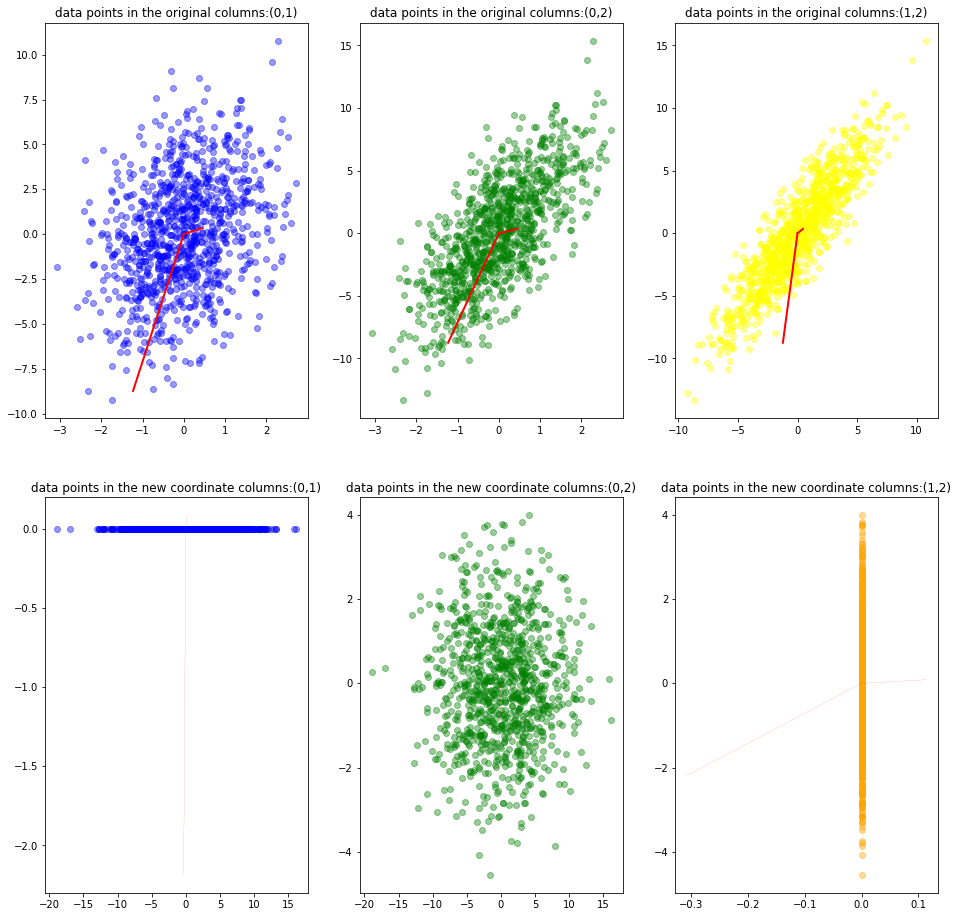

In [31]:
#Plot the data points in the original

plt.figure(figsize=(10,10))
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(nrows=2, ncols=3, figsize=(16, 16))

scale_factor=0.4

ax1.scatter(dataset_matrix[0,:], dataset_matrix[1,:], alpha=0.4,color='blue')
for li, vi in zip(eig_vals, eig_vecs.T):
    ax1.plot([0, scale_factor*li*vi[0]], [0, scale_factor*li*vi[2]], 'r-', lw=2)
ax1.set_title('data points in the original columns:(0,1)')

ax2.scatter(dataset_matrix[0,:], dataset_matrix[2,:], alpha=0.4 ,color='green')
for li, vi in zip(eig_vals, eig_vecs.T):
    ax2.plot([0, scale_factor*li*vi[0]], [0, scale_factor*li*vi[2]], 'r-', lw=2)
ax2.set_title('data points in the original columns:(0,2)')

ax3.scatter(dataset_matrix[1,:], dataset_matrix[2,:], alpha=0.4,color='yellow')
for li, vi in zip(eig_vals, eig_vecs.T):
    ax3.plot([0, scale_factor*li*vi[0]], [0, scale_factor*li*vi[2]], 'r-', lw=2)
ax3.set_title('data points in the original columns:(1,2)')


#Plot the data points in the  new coordinate
scale_factor_=0.1
ax4.scatter(new_dataset[0,:], new_dataset[1,:], alpha=0.4,color='blue')
for li, vi in zip(eig_vals, eig_vecs.T):
    ax4.plot([0, scale_factor_*li*vi[0]], [0, scale_factor_*li*vi[2]], 'r-', lw=0.1)
ax4.set_title('data points in the new coordinate columns:(0,1)')

ax5.scatter(new_dataset[0,:], new_dataset[2,:], alpha=0.4 ,color='green')
for li, vi in zip(eig_vals, eig_vecs.T):
    ax5.plot([0, scale_factor_*li*vi[0]], [0, scale_factor_*li*vi[2]], 'r-', lw=0.1)
ax5.set_title('data points in the new coordinate columns:(0,2)')

ax6.scatter(new_dataset[1,:], new_dataset[2,:], alpha=0.4,color='orange')
for li, vi in zip(eig_vals, eig_vecs.T):
    ax6.plot([0, scale_factor_*li*vi[0]], [0, scale_factor_*li*vi[2]], 'r-', lw=0.1)
ax6.set_title('data points in the new coordinate columns:(1,2)')


2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [32]:
# Start from the dataset you have genereted in the previous exercise  
N=1000
x1=np.random.normal(loc=0, scale=1,size=N)
x2=x1+np.random.normal(loc=0,scale=3,size=N)
x3=2*x1+x2

# add uncorrelated random noise
sigmas=np.array([1/(50+10*i) for i in range(0,10)])
noise=np.empty((N,10))
for i,j in enumerate(sigmas):
    noise[:,i]=np.random.randn(N)*j
old_dataset_matrix=np.array([x1,x2,x3])
new_dataset_matrix=np.hstack([old_dataset_matrix.T,noise])
cov_matrix = np.cov(new_dataset_matrix.T)

#Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
eig_vals, eig_vecs =la.eig(cov_matrix)

#Find the eigenvectors and eigenvalues using SVD,Check that the two procedures yield to same result
U, s, V = np.linalg.svd(dataset_matrix)
eig_vals_svd = s**2/(N-1)
eig_vecs_svd = U
print("shapes of svd :",'\n', U.shape,  s.shape, V.shape)
print('Eigenvectors of the covariance matrix svd: ','\n',eig_vals_svd,'\n')
print('Eigenvalues of the covariance matrix svd: ','\n',eig_vecs_svd,'\n')

Newdata=np.dot(eig_vecs.T,new_dataset_matrix.T)
print('show the dataset with adding uncorrelated random noise:','\n',Newdata)

shapes of svd : 
 (3, 3) (3,) (1000, 1000)
Eigenvectors of the covariance matrix svd:  
 [2.70925123e+01 2.00316583e+00 2.58057579e-32] 

Eigenvalues of the covariance matrix svd:  
 [[-0.11350804  0.56608238 -0.81649658]
 [-0.57979845 -0.70510077 -0.40824829]
 [-0.80681453  0.42706399  0.40824829]] 

show the dataset with adding uncorrelated random noise: 
 [[-8.59438587e-01  4.97897676e+00 -9.31397320e-01 ...  1.11665934e+01
   8.06412035e+00  7.70941794e+00]
 [ 2.21896421e+00 -1.50544536e+00 -8.27453097e-01 ...  5.21189789e-01
   1.30942611e+00  1.72845869e+00]
 [ 6.79585650e-03  1.20675023e-02 -7.73095048e-03 ... -1.09048381e-02
   1.54637609e-02 -3.60580967e-02]
 ...
 [-8.91087534e-03  1.72140118e-02 -8.80564312e-04 ...  3.44198575e-03
  -1.26167030e-02 -1.28359613e-03]
 [ 2.25203143e-03 -3.09614593e-03  8.77170821e-03 ...  5.90864834e-03
   4.12916466e-03 -5.38230851e-03]
 [ 2.47801842e-04 -1.68187829e-02 -6.67121615e-03 ... -1.69558579e-03
  -3.33101463e-03  6.25006004e-03]]


C:\Users\pc\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'data points in the new coordinate columns:(1,2)')

<Figure size 720x720 with 0 Axes>

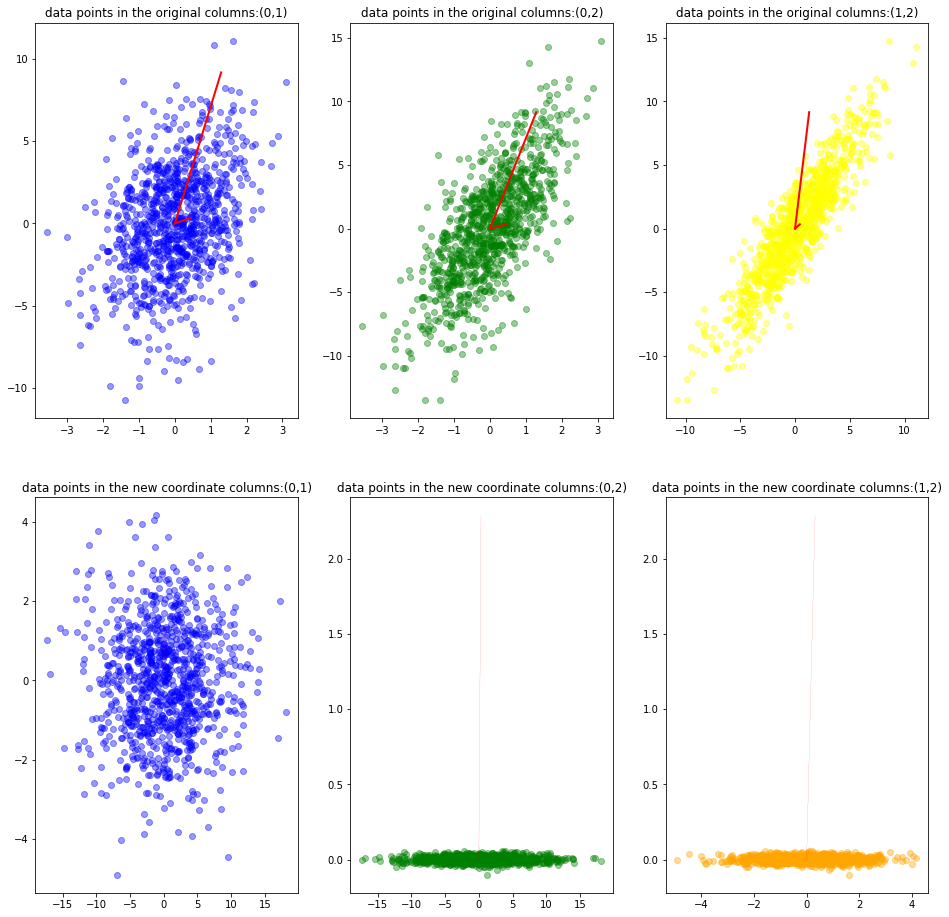

In [4]:
#Repeat the PCA procedure and compare the results with what you obtained before
plt.figure(figsize=(10,10))
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(nrows=2, ncols=3, figsize=(16, 16))

scale_factor=0.4

ax1.scatter(old_dataset_matrix[0,:], old_dataset_matrix[1,:], alpha=0.4,color='blue')
for li, vi in zip(eig_vals, eig_vecs.T):
    ax1.plot([0, scale_factor*li*vi[0]], [0, scale_factor*li*vi[2]], 'r-', lw=2)
ax1.set_title('data points in the original columns:(0,1)')

ax2.scatter(old_dataset_matrix[0,:], old_dataset_matrix[2,:], alpha=0.4 ,color='green')
for li, vi in zip(eig_vals, eig_vecs.T):
    ax2.plot([0, scale_factor*li*vi[0]], [0, scale_factor*li*vi[2]], 'r-', lw=2)
ax2.set_title('data points in the original columns:(0,2)')

ax3.scatter(old_dataset_matrix[1,:], old_dataset_matrix[2,:], alpha=0.4,color='yellow')
for li, vi in zip(eig_vals, eig_vecs.T):
    ax3.plot([0, scale_factor*li*vi[0]], [0, scale_factor*li*vi[2]], 'r-', lw=2)
ax3.set_title('data points in the original columns:(1,2)')


#Plot the data points in the  new coordinate
scale_factor_=0.1
ax4.scatter(Newdata[0,:], Newdata[1,:], alpha=0.4,color='blue')
for li, vi in zip(eig_vals, eig_vecs.T):
    ax4.plot([0, scale_factor_*li*vi[0]], [0, scale_factor_*li*vi[2]], 'r-', lw=0.1)
ax4.set_title('data points in the new coordinate columns:(0,1)')

ax5.scatter(Newdata[0,:], Newdata[2,:], alpha=0.4 ,color='green')
for li, vi in zip(eig_vals, eig_vecs.T):
    ax5.plot([0, scale_factor_*li*vi[0]], [0, scale_factor_*li*vi[2]], 'r-', lw=0.1)
ax5.set_title('data points in the new coordinate columns:(0,2)')

ax6.scatter(Newdata[1,:], Newdata[2,:], alpha=0.4,color='orange')
for li, vi in zip(eig_vals, eig_vecs.T):
    ax6.plot([0, scale_factor_*li*vi[0]], [0, scale_factor_*li*vi[2]], 'r-', lw=0.1)
ax6.set_title('data points in the new coordinate columns:(1,2)') 


3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

In [5]:
file_name="magic04.data"
data=pd.read_csv(file_name,header=None)
dataset=np.array(data.iloc[:,0:10])


In [6]:
cov_matrix = np.cov(dataset.T)
print('covariance matrix of the dataset','\n',cov_matrix,'\n')

covariance matrix of the dataset 
 [[ 1.79478093e+03  5.98863542e+02  1.40642293e+01 -4.88699477e+00
  -2.80038030e+00 -9.24434103e+02 -2.58727155e+02  1.18140078e+01
  -9.70681761e+00  1.32486413e+03]
 [ 5.98863542e+02  3.36577782e+02  6.22110176e+00 -2.04513685e+00
  -1.17822641e+00 -2.89972346e+02 -1.64893734e+02  1.51860869e+01
   3.16366938e+01  4.61786200e+02]
 [ 1.40642293e+01  6.22110176e+00  2.23349483e-01 -7.35110795e-02
  -4.22432318e-02 -4.47307815e+00  2.29353454e+00  1.52121337e-01
  -2.30292484e+00  1.54354673e+01]
 [-4.88699477e+00 -2.04513685e+00 -7.35110795e-02  3.34206468e-02
   1.97262797e-02  1.21519489e+00 -1.13652751e+00 -4.30025009e-02
   1.12273751e+00 -4.48566053e+00]
 [-2.80038030e+00 -1.17822641e+00 -4.22432318e-02  1.97262797e-02
   1.22126367e-02  6.55332684e-01 -6.69389146e-01 -2.52390547e-02
   6.62907179e-01 -2.51579453e+00]
 [-9.24434103e+02 -2.89972346e+02 -4.47307815e+00  1.21519489e+00
   6.55332684e-01  3.50535778e+03  8.27482747e+02  3.14793086e+0

In [7]:
eig_vals, eig_vecs =la.eig(cov_matrix)

new_dataset = np.dot(eig_vecs.T,dataset.T)
print('show new datasets:','\n',new_dataset)

show new datasets: 
 [[ 6.67708977e+01  1.74588255e+02  2.43440502e+02 ...  2.47779335e+02
   3.96071821e+02  3.72581595e+02]
 [-5.55981920e+01 -1.09891592e+02 -1.11280406e+02 ... -1.05154801e+02
  -8.79691505e+01  1.33879729e+02]
 [ 1.37829286e+01  3.39871285e+01  1.62323113e+02 ...  1.00069546e+01
   1.57616635e+02  9.26848012e+01]
 ...
 [-1.98836582e+00 -1.64592215e+00 -1.42265534e+00 ... -2.07450302e+00
  -2.32252957e+00 -1.78199025e+00]
 [-1.34868237e+00 -1.49306113e+00 -1.42031968e+00 ... -1.33914343e+00
  -1.43052509e+00 -1.41559577e+00]
 [ 1.10405481e-01  3.53373375e-02  9.38171703e-02 ...  1.10233894e-01
   8.33728644e-02  1.06071325e-01]]


(6579.791399778602+0j) [ 3.27812305e-01  1.13810001e-01  3.06076690e-03 -9.27109146e-04
 -5.21882399e-04 -3.80700011e-01 -7.16522956e-02  3.37405774e-03
 -5.35411190e-02  8.52426707e-01]
(3853.870481819947+0j) [ 1.34406332e-01  5.38837224e-02 -6.59372017e-04  2.58205308e-04
  1.52710005e-04 -6.93897410e-01 -5.62620169e-01  1.03235567e-03
  1.18351409e-01 -4.08641365e-01]
(2016.3831284182884+0j) [-6.55078481e-02  1.89938175e-02 -1.05931761e-03  5.10399700e-04
  2.94635944e-04  5.40076835e-01 -8.13121108e-01  1.24715329e-02
  5.31065391e-02  1.98800703e-01]
(1326.7596783587828+0j) [-0.86398825 -0.31976648 -0.00693029  0.00260555  0.00151276 -0.28513022
 -0.07588446 -0.01189481 -0.09251386  0.23549647]
(610.1872593818977+0j) [-9.45511967e-02  1.97548493e-02 -2.65185255e-03  1.53899865e-03
  9.19340567e-04  5.48387919e-03  1.02210804e-01  9.75590040e-03
  9.84242210e-01  1.06557705e-01]
(433.59917117483803+0j) [ 1.98552026e-02 -2.32592322e-02 -1.33441545e-04  3.46437681e-05
  2.21501607e-0

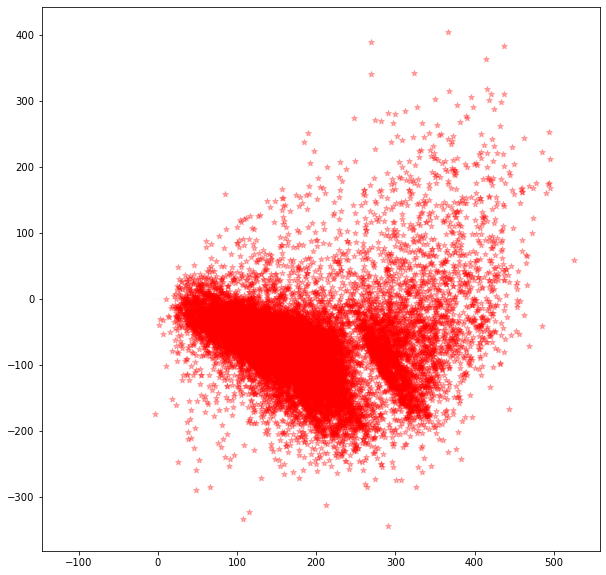

In [28]:
plt.figure(figsize=(10,10))

plt.scatter(new_dataset[0,:], new_dataset[1,:], alpha=0.3,color='r',marker='*')

# a scale factor to emphazise the lines 
scale_factor=0.1

# draw each eigenvector
for li, vi in zip(eig_vals, eig_vecs.T):
    print (li, vi)
    # the line is defined by means of its beginning and its end 
    plt.plot([0, scale_factor*li*vi[0]], [0, scale_factor*li*vi[1]], 'r-', lw=0.01)

 